# BeatBag
This is an entry in the SparkFun Crowdsourcing Algorithms Contest: https://www.sparkfun.com/news/2115

In [1]:
import numpy as np
import csv
import math

from IPython import display
import time

import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
def lpf(alpha, x, y_old):
    return (y_old + alpha * (x - y_old))

def hpf(alpha, x, x_old, y_old):
    return (alpha * (y_old + x - x_old))

def vector_mag(x,y):
    return (np.sqrt(x**2 + y**2))

def goertzel(samples, sample_rate, *freqs):
    """
    Lifted from this guy: https://gist.github.com/sebpiq/4128537
    
    Implementation of the Goertzel algorithm, useful for calculating individual
    terms of a discrete Fourier transform.
    `samples` is a windowed one-dimensional signal originally sampled at `sample_rate`.
    The function returns 2 arrays, one containing the actual frequencies calculated,
    the second the coefficients `(real part, imag part, power)` for each of those frequencies.
    For simple spectral analysis, the power is usually enough.
    Example of usage :
        
        freqs, results = goertzel(some_samples, 44100, (400, 500), (1000, 1100))
    """
    window_size = len(samples)
    f_step = sample_rate / float(window_size)
    f_step_normalized = 1.0 / window_size

    # Calculate all the DFT bins we have to compute to include frequencies
    # in `freqs`.
    bins = set()
    for f_range in freqs:
        f_start, f_end = f_range
        k_start = int(math.floor(f_start / f_step))
        k_end = int(math.ceil(f_end / f_step))

        if k_end > window_size - 1: raise ValueError('frequency out of range %s' % k_end)
        bins = bins.union(range(k_start, k_end))

    # For all the bins, calculate the DFT term
    n_range = range(0, window_size)
    freqs = []
    results = []
    for k in bins:

        # Bin frequency and coefficients for the computation
        f = k * f_step_normalized
        w_real = 2.0 * math.cos(2.0 * math.pi * f)
        w_imag = math.sin(2.0 * math.pi * f)

        # Doing the calculation on the whole sample
        d1, d2 = 0.0, 0.0
        for n in n_range:
            y  = samples[n] + w_real * d1 - d2
            d2, d1 = d1, y

        # Storing results `(real part, imag part, power)`
        results.append((
            0.5 * w_real * d1 - d2, w_imag * d1,
            d2**2 + d1**2 - w_real * d1 * d2)
        )
        freqs.append(f * sample_rate)
    return freqs, results

## Locate the data

In [3]:
data_path = '.\\data\\Recorded Tests\\'
#data_path +=  '3-77hits.TXT'
data_path +=  '4-81hits.TXT'
#data_path +=  '5-93hits.TXT'
#data_path +=  '6-79hits.TXT'
#data_path +=  'MysteryDataSet-1.TXT'
#data_path +=  'MysteryDataSet-2.TXT'

## Initialize variables

In [4]:
sampletime = 0.002
timeconstant_lpf = 0.2
alpha_lpf = (float)(sampletime / (sampletime+timeconstant_lpf))

timeconstant_hpf = 0.8
alpha_hpf = (float)(sampletime / (sampletime+timeconstant_hpf))

x_lpf=0.0
y_lpf=0.0
z_lpf=0.0

x_lpf_old=0.0
y_lpf_old=0.0
z_lpf_old=0.0

x_hpf=0.0
y_hpf=0.0
z_hpf=0.0

x_hpf_old=0.0
y_hpf_old=0.0
z_hpf_old=0.0

## Read and process each line of the file

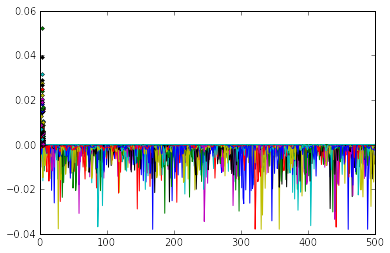

34 34


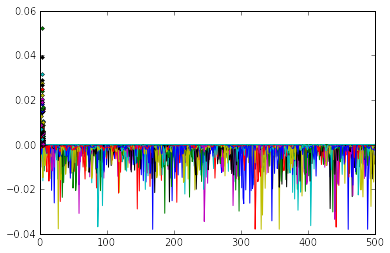

In [16]:
i=0
count=0
hitcount = 0
ARRAYSIZE = 500
myvec_z=np.zeros(ARRAYSIZE)
#myvec_c=np.zeros(ARRAYSIZE)
#x=0.0
#y=0.0
z=0.0

fig, ax = plt.subplots()

with open(data_path, 'rb') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        try:           
            timestamp_ms, x, y, z = row
        except ValueError:
            pass
        
        #x=float(x)
        #y=float(y)
        z=float(z)+500.0

        #Signal Processing
        #for now, this is lowpass followed by high pass filters.
        #later, time dependent filter vaules
        #x_lpf = lpf(alpha_lpf, x, x_lpf)
        #x_hpf = hpf(alpha_hpf, x_lpf, x_lpf_old, x_hpf_old)
        #x_lpf_old = x_lpf
        #x_hpf_old = x_hpf
        
        #y_lpf = lpf(alpha_lpf, y, y_lpf)
        #y_hpf = hpf(alpha_hpf, y_lpf, y_lpf_old, y_hpf_old)
        #y_lpf_old = y_lpf
        #y_hpf_old = y_hpf

        z_lpf = lpf(alpha_lpf, z, z_lpf)
        z_hpf = hpf(alpha_hpf, z_lpf, z_lpf_old, z_hpf_old)
        z_lpf_old = z_lpf
        z_hpf_old = z_hpf        
                
        #calculate a vector in plane of the bag platform
        #c = vector_mag(x_hpf, y_hpf)   

        #trying to do fifo/circular buffer
        myvec_z=np.roll(myvec_z, -1)
        myvec_z=np.delete(myvec_z, ARRAYSIZE-1)
        myvec_z=np.append(myvec_z,float(min(z_hpf,0)))
#        myvec_z=np.append(myvec_z,float(min(z,0)))
#        myvec_z=np.append(myvec_z, z)
        
        i+=1
        if (i==ARRAYSIZE): #when buffer full, ship to processing
            count+=1
#            plt.plot(myvec_z)
            freqs, results = goertzel(myvec_z, 1/sampletime, (1, 5))

            bb = np.array(results)[2,2]
            if bb>0:
                hitcount+=1
                
            #reset buffer, counter
            myvec_z=np.zeros(ARRAYSIZE)
            i=0
            
            #live update
            ax.plot(freqs, np.array(results)[:,2], '.')
            display.clear_output(wait=True)
            display.display(plt.gcf())

print count, hitcount

In [15]:
print freqs, results

[1.0, 2.0, 3.0, 4.0] [(-0.0055112397391836598, -0.011330486394538892, 0.00015875368539952639), (0.0084775896179070109, -0.0097135607835574529, 0.00016622278882549857), (0.011670043021980131, 0.0034746696582223973, 0.00014826323336863956), (0.0032186330372894478, 0.012297043759455667, 0.00016157688385069757)]


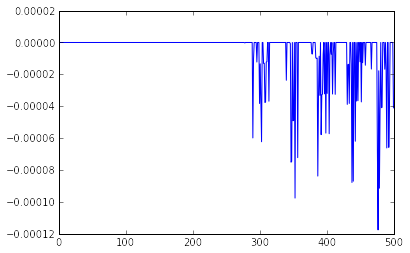

In [13]:
plt.plot(myvec_z)